In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer,OneHotEncoder
from pyspark.sql import SQLContext, SparkSession, Row
from pyspark.mllib.stat import Statistics
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark.sql.functions import when, count, isnull
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import FloatType

from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.functions import vector_to_array

import pyspark.sql.functions as F

spark = SparkSession.Builder().appName('DDAM_Project_est').getOrCreate()
df = spark.read.options(inferSchema = True, delimiter = ',', header = True).csv('../../Datasets/East_Incidents_Cleaned.csv')
df.show()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/13 21:32:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/13 21:32:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+-------------------+------------------+------------------+-----------+---------+---------+-----+-------------+-------------+-------------+--------------+--------------+----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-----+---------------+----+------+---------------+---------------------+
|Severity|         Start_Time|         Start_Lat|         Start_Lng|Distance_mi|     City|   County|State|Temperature_F|Humidity_perc|Visibility_mi|Wind_Direction|Wind_Speed_mph|Precipitation_in|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|month|day_of_the_week|hour|season|Working_Weekend|Astronomical_Twilight|
+--------+-------------------+------------------+------------------+-----------+---------+---------+-----+-------------+-------------+-------------+--------------+--------------+----------------+-------

Preparing data for MLP classification

In [2]:
to_drop=['Start_Time','City','County','State','Wind_Direction','day_of_the_week','season']
df_class=df.drop(*to_drop)
colonne_booleane = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']

# Converti le colonne booleane in numeriche
for col_name in colonne_booleane:
    df_class = df_class.withColumn(col_name, col(col_name).cast("int"))


df_class = df_class.withColumn("Astronomical_Twilight", when(df_class["Astronomical_Twilight"] == 'Day', 0).otherwise(1))
df_class = df_class.withColumn("Working_Weekend", when(df_class["Working_Weekend"] == 'WorkingDay', 0).otherwise(1))




indexer = StringIndexer(inputCol='Weather_Condition', outputCol='class_numeric')
indexer_fitted = indexer.fit(df_class)
df_indexed = indexer_fitted.transform(df_class)


encoder = OneHotEncoder(inputCols=['class_numeric'], outputCols=['class_onehot'],dropLast=False)
df_onehot = encoder.fit(df_indexed).transform(df_indexed)


df_col_onehot = df_onehot.select('*', vector_to_array('class_onehot').alias('col_onehot'))

num_categories = len(df_col_onehot.first()['col_onehot'])   # 3
cols_expanded = [(F.col('col_onehot')[i].alias(f'{indexer_fitted.labels[i]}')) for i in range(num_categories)]
df_cols_onehot = df_col_onehot.select('Severity',
 'Start_Lat',
 'Start_Lng',
 'Distance_mi',
 'Temperature_F',
 'Humidity_perc',
 'Visibility_mi',
 'Wind_Speed_mph',
 'Precipitation_in',
 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'month',
 'hour',
 'Working_Weekend',
 'Astronomical_Twilight', *cols_expanded)


num_col = [item[0] for item in df_cols_onehot.dtypes if not item[1].startswith('string')]
num_col.remove("Severity")

num_col_ww=[item[0] for item in df_cols_onehot.dtypes if not item[1].startswith('string')]
num_col_ww.remove("Working_Weekend")

df_MLP= df_cols_onehot.withColumn("Severity", col("Severity") - 1)
df_MLP.show()

+--------+------------------+------------------+-----------+-------------+-------------+-------------+--------------+----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-----+----+---------------+---------------------+------+------+----+----+-----+
|Severity|         Start_Lat|         Start_Lng|Distance_mi|Temperature_F|Humidity_perc|Visibility_mi|Wind_Speed_mph|Precipitation_in|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|month|hour|Working_Weekend|Astronomical_Twilight|Normal|Cloudy|Rain|Snow|Foggy|
+--------+------------------+------------------+-----------+-------------+-------------+-------------+--------------+----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-----+----+---------------+---------------------+------+------+----+----+-----+
|       1|         33.032

In [3]:
df_MLP_binary=df_MLP

Discovering Severity distribution before train e test split

In [4]:
severity_counts = df_MLP.groupBy("Severity").count()
severity_counts.show()

+--------+------+
|Severity| count|
+--------+------+
|       1|352058|
|       3| 15637|
|       2| 14162|
|       0| 12662|
+--------+------+



Vectorizing data with respect to Severity

In [5]:
assembler = VectorAssembler(inputCols=num_col, outputCol="features")

output_dataset = assembler.transform(df_MLP)

classificationData = output_dataset.select("features", "Severity")

classificationData.show(truncate=False)
(trainingData, testData) = classificationData.randomSplit([0.7, 0.3],seed=0)

+-----------------------------------------------------------------------------------------------------------+--------+
|features                                                                                                   |Severity|
+-----------------------------------------------------------------------------------------------------------+--------+
|(29,[0,1,3,4,5,17,20,21,24],[33.032551,-81.346909,30.0,93.0,10.0,1.0,3.0,6.0,1.0])                         |1       |
|(29,[0,1,2,3,4,5,6,17,20,21,25],[33.023018,-81.274361,0.129,73.0,47.0,10.0,6.0,1.0,3.0,14.0,1.0])          |1       |
|(29,[0,1,2,3,4,5,6,20,21,24],[33.023848,-81.33301800000002,0.122,82.0,15.0,10.0,7.0,3.0,14.0,1.0])         |1       |
|(29,[0,1,3,4,5,20,21,28],[33.087425,-81.208588,46.0,100.0,0.25,3.0,7.0,1.0])                               |1       |
|(29,[0,1,3,4,5,17,20,21,24],[33.06987,-81.424118,59.0,94.0,10.0,1.0,3.0,6.0,1.0])                          |1       |
|(29,[0,1,3,4,5,10,14,20,21,25],[32.920799,-81.2

Discovering Severity trainingData e testData distribution

In [6]:
severity_counts_train= trainingData.groupBy("Severity").count()
severity_counts_train.show()

+--------+------+
|Severity| count|
+--------+------+
|       1|246719|
|       3| 10917|
|       2|  9845|
|       0|  8927|
+--------+------+



In [7]:
severity_counts_test= testData.groupBy("Severity").count()

# Mostra il risultato
severity_counts_test.show()

+--------+------+
|Severity| count|
+--------+------+
|       1|105339|
|       3|  4720|
|       2|  4317|
|       0|  3735|
+--------+------+



Training & Testing a non tuned MLP with trainingData  not yet sampled

In [8]:
# MLP Layers  -> output layer must have the same number of units of the Severity classes
layers = [len(num_col),4]

# Create the Multilayer Perceptron Classifier and set its parameters
trainer = MultilayerPerceptronClassifier(
    layers=layers,
    labelCol="Severity",
    featuresCol="features",
    maxIter=500,  
    tol=1e-6,
    seed=None,
    blockSize=32,
    stepSize=0.03,  
    solver="l-bfgs",
    initialWeights=None,
    probabilityCol="probability",
    rawPredictionCol="rawPrediction"
)

# Train the model
model = trainer.fit(trainingData)

# Make predictions on the test set
predictions= model.transform(testData)

# Compute Test Error = 1-Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(f'Accuracy:{accuracy}\n')
print("Test Error = %g" % (1.0 - accuracy))

#Computing confusion matrix
preds_and_labels = predictions.select(['prediction','Severity']).withColumn('label', F.col('Severity').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix())

23/12/13 20:53:25 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=44430Kb max_used=44430Kb free=86641Kb
 bounds [0x000000010a9d8000, 0x000000010d578000, 0x00000001129d8000]
 total_blobs=15054 nmethods=13868 adapters=1094
 compilation: disabled (not enough contiguous free space left)


Accuracy:0.8931174911735571

Test Error = 0.106883


/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


DenseMatrix([[5.15000e+02, 3.22000e+03, 0.00000e+00, 0.00000e+00],
             [3.67000e+02, 1.04972e+05, 0.00000e+00, 0.00000e+00],
             [1.30000e+01, 4.30400e+03, 0.00000e+00, 0.00000e+00],
             [8.00000e+00, 4.71200e+03, 0.00000e+00, 0.00000e+00]])


Precision for class  0 : 57.03%
Recall for class  0 : 13.79%
avg_F1-Score for class  0 : 22.21%
----------------------------
Precision for class  1 : 89.56%
Recall for class  1 : 99.65%
avg_F1-Score for class  1 : 94.34%
----------------------------
Precision for class  2 : 0.00%
Recall for class  2 : 0.00%
avg_F1-Score for class  2 : 0.00%
----------------------------
Precision for class  3 : 0.00%
Recall for class  3 : 0.00%
avg_F1-Score for class  3 : 0.00%
----------------------------
[0.22207848210435532, 0.943369265818007, 0.0, 0.0]
----------------------
avg_F1-Score: 29.14%


<AxesSubplot:>

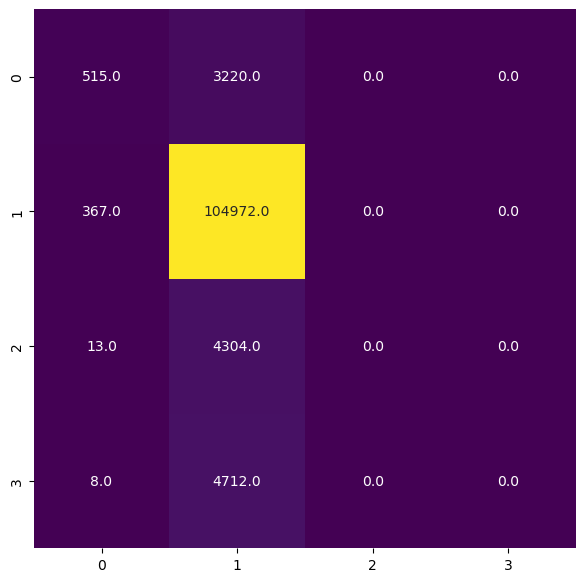

In [9]:
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

As we can see from the results accuracy is very high because the model predict only the labels 1, cause of the unbalanced data. Now we have to sample the training set trying the define a model well trained and that can predict each labels on the test set.

Performing Undersampling(Severity=1) on trainingData

Undersampling -> Faccio una media delle occorrenze delle altre tre classi e riduco la classe di maggioranza a quel numero

In [10]:
g=trainingData.groupBy('Severity').agg(F.count('Severity').alias('Count'))
g=g.sort('Severity')
g_p=g.toPandas()
n_0=g_p.iloc[0,1]
n_1=g_p.iloc[1,1]
n_2=g_p.iloc[2,1]
n_3=g_p.iloc[3,1]

In [11]:
und=(n_0+n_2+n_3)/3
train_und = trainingData.sampleBy('Severity', fractions={0:1.0 ,1: und/n_1 , 2:1.0, 3:1.0})
result_counts=train_und.groupBy("Severity").count()
result_counts.show()

+--------+-----+
|Severity|count|
+--------+-----+
|       1| 9883|
|       3|10917|
|       2| 9845|
|       0| 8927|
+--------+-----+



Training & Testing a non tuned MLP with trainingData sampled

In [12]:
# MLP Layers  -> output layer must have the same number of units of the Severity classes
layers = [len(num_col),4]

# Create the Multilayer Perceptron Classifier and set its parameters
trainer = MultilayerPerceptronClassifier(
    layers=layers,
    labelCol="Severity",
    featuresCol="features",
    maxIter=500,  
    tol=1e-6,
    seed=None,
    blockSize=32,
    stepSize=0.03,  
    solver="l-bfgs",
    initialWeights=None,
    probabilityCol="probability",
    rawPredictionCol="rawPrediction"
)

# Train the model
model = trainer.fit(train_und)

# Make predictions on the test set
predictions= model.transform(testData)

# Compute Test Error = 1-Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(f'Accuracy:{accuracy}\n')
print("Test Error = %g" % (1.0 - accuracy))

#Computing confusion matrix
preds_and_labels = predictions.select(['prediction','Severity']).withColumn('label', F.col('Severity').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix())

Accuracy:0.2769936754408988

Test Error = 0.723006


/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


DenseMatrix([[ 3174.,    67.,   382.,   112.],
             [12690., 25042., 37936., 29671.],
             [  788.,   369.,  2518.,   642.],
             [  445.,   811.,  1482.,  1982.]])


Precision for class  0 : 18.56%
Recall for class  0 : 84.98%
avg_F1-Score for class  0 : 30.47%
----------------------------
Precision for class  1 : 95.26%
Recall for class  1 : 23.77%
avg_F1-Score for class  1 : 38.05%
----------------------------
Precision for class  2 : 5.95%
Recall for class  2 : 58.33%
avg_F1-Score for class  2 : 10.80%
----------------------------
Precision for class  3 : 6.12%
Recall for class  3 : 41.99%
avg_F1-Score for class  3 : 10.68%
----------------------------
[0.30472350230414746, 0.38049655088582973, 0.10798756298917121, 0.10676865892746519]
----------------------
avg_F1-Score: 22.50%


<AxesSubplot:>

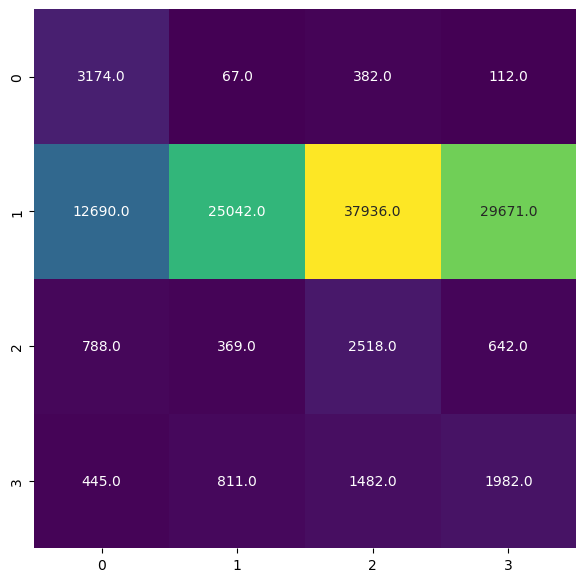

In [13]:
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

As we can see now the model can predict each of the 4 classes, as expected the accuracy now it is much lower

Training & Testing(on the train itself) a non tuned MLP with trainingData sampled

In [14]:
# MLP Layers  -> output layer must have the same number of units of the Severity classes
layers = [len(num_col),4]

# Create the Multilayer Perceptron Classifier and set its parameters
trainer = MultilayerPerceptronClassifier(
    layers=layers,
    labelCol="Severity",
    featuresCol="features",
    maxIter=500,  
    tol=1e-6,
    seed=None,
    blockSize=32,
    stepSize=0.03,  
    solver="l-bfgs",
    initialWeights=None,
    probabilityCol="probability",
    rawPredictionCol="rawPrediction"
)

# Train the model
model = trainer.fit(train_und)

# Make predictions on the test set
predictions= model.transform(train_und)

# Compute Test Error = 1-Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(f'Accuracy:{accuracy}\n')
print("Test Error = %g" % (1.0 - accuracy))

#Computing confusion matrix
preds_and_labels = predictions.select(['prediction','Severity']).withColumn('label', F.col('Severity').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix())

Accuracy:0.5073789548165369

Test Error = 0.492621


DenseMatrix([[7522.,  223.,  903.,  279.],
             [1197., 2361., 3587., 2738.],
             [1784.,  786., 5656., 1619.],
             [1028., 1875., 3475., 4539.]])


Precision for class  0 : 65.23%
Recall for class  0 : 84.26%
avg_F1-Score for class  0 : 73.54%
----------------------------
Precision for class  1 : 45.01%
Recall for class  1 : 23.89%
avg_F1-Score for class  1 : 31.21%
----------------------------
Precision for class  2 : 41.52%
Recall for class  2 : 57.45%
avg_F1-Score for class  2 : 48.21%
----------------------------
Precision for class  3 : 49.47%
Recall for class  3 : 41.58%
avg_F1-Score for class  3 : 45.18%
----------------------------
[0.7353602502688433, 0.3121364357482813, 0.4820591494076536, 0.4518216205454907]
----------------------
avg_F1-Score: 49.53%


<AxesSubplot:>

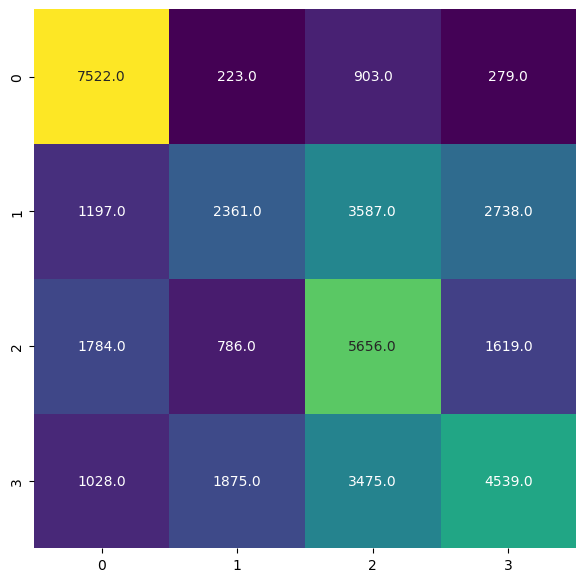

In [15]:
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

Performing Undersampling(Severity=1) & Oversampling(Severity=0,2,3) 

In [16]:
under_1=trainingData.filter(col('Severity') == 1)
under_1 = trainingData.sample(True, 0.3, seed=42)

In [17]:
oversample_0=trainingData.filter(col('Severity') == 0)
num_campioni_da_generare = round(n_1*0.3)
num_campioni_da_generare=(num_campioni_da_generare-n_0)/n_0 
full_0=oversample_0

while num_campioni_da_generare>1:
    oversample_0 = oversample_0.unionAll(full_0)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    print(num_campioni_da_generare)
    
df_minority_oversampled = full_0.sample(True, num_campioni_da_generare, seed=42)

oversample_0 = oversample_0.unionAll(df_minority_oversampled)

6.291251260221799
5.291251260221799
4.291251260221799
3.2912512602217987
2.2912512602217987
1.2912512602217987
0.2912512602217987


In [18]:
oversample_2=trainingData.filter(col('Severity') == 2)
num_campioni_da_generare = round(n_1*0.3)
num_campioni_da_generare=(num_campioni_da_generare-n_2)/n_2
full_2=oversample_2

while num_campioni_da_generare>1:
    oversample_2 = oversample_2.unionAll(full_2)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    print(num_campioni_da_generare)
    
df_minority_oversampled = full_2.sample(True, num_campioni_da_generare, seed=42)

oversample_2 = oversample_2.unionAll(df_minority_oversampled)

5.518131030980193
4.518131030980193
3.518131030980193
2.518131030980193
1.518131030980193
0.518131030980193


In [19]:
oversample_3=trainingData.filter(col('Severity') == 3)
num_campioni_da_generare = round(n_1*0.3)
num_campioni_da_generare=(num_campioni_da_generare-n_3)/n_3  
full_3=oversample_3

while num_campioni_da_generare>1:
    oversample_3 = oversample_3.unionAll(full_3)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    print(num_campioni_da_generare)
    
df_minority_oversampled = full_3.sample(True, num_campioni_da_generare, seed=42)

oversample_3 = oversample_3.unionAll(df_minority_oversampled)

4.779884583676834
3.779884583676834
2.779884583676834
1.779884583676834
0.779884583676834


In [20]:
class0_counts=oversample_0.count()
class2_counts=oversample_2.count()
class3_counts=oversample_3.count()
class1_counts=under_1.count()
print(f'Class 0: {class0_counts}\nClass 1: {class1_counts}\nClass 2: {class2_counts}\nClass 3: {class3_counts}')

Class 0: 73995
Class 1: 83020
Class 2: 74001
Class 3: 73868


In [21]:
train_und_over=oversample_0.unionAll(oversample_2).unionAll(oversample_3).unionAll(under_1)

In [22]:
g=train_und_over.groupBy('Severity').agg(F.count('Severity').alias('Count'))
g=g.sort('Severity')
g.show()

23/12/13 21:02:13 WARN DAGScheduler: Broadcasting large task binary with size 1491.6 KiB


+--------+-----+
|Severity|Count|
+--------+-----+
|       0|76741|
|       1|74068|
|       2|76985|
|       3|77090|
+--------+-----+



Training a tuned MLP with trainingData sampled

In [23]:
# MLP Layers  -> output layer must have the same number of units of the Severity classes
layers = [len(num_col),4]

# Create the Multilayer Perceptron Classifier and set its parameters
trainer = MultilayerPerceptronClassifier(
    layers=layers,
    labelCol="Severity",
    featuresCol="features",
    maxIter=500,  
    tol=1e-6,
    seed=None,
    blockSize=32,
    stepSize=0.03,  
    solver="l-bfgs",
    initialWeights=None,
    probabilityCol="probability",
    rawPredictionCol="rawPrediction"
)

# Train the model
model = trainer.fit(train_und_over)

# Make predictions on the test set
predictions= model.transform(testData)

# Compute Test Error = 1-Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(f'Accuracy:{accuracy}\n')
print("Test Error = %g" % (1.0 - accuracy))

#Computing confusion matrix
preds_and_labels = predictions.select(['prediction','Severity']).withColumn('label', F.col('Severity').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix())

23/12/13 21:03:16 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/13 21:03:34 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/13 21:03:35 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/13 21:03:35 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/13 21:03:36 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/13 21:03:36 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/13 21:03:37 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/13 21:03:37 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/13 21:03:38 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/13 21:03:38 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/13 21:03:39 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/13 21:03:39 WARN DAGScheduler: Broadcasting larg

Accuracy:0.29481589352388854

Test Error = 0.705184


DenseMatrix([[ 3243.,    60.,   355.,    77.],
             [13544., 27206., 40258., 24331.],
             [  836.,   336.,  2635.,   510.],
             [  485.,   909.,  1589.,  1737.]])


Precision for class  0 : 17.91%
Recall for class  0 : 86.83%
avg_F1-Score for class  0 : 29.69%
----------------------------
Precision for class  1 : 95.42%
Recall for class  1 : 25.83%
avg_F1-Score for class  1 : 40.65%
----------------------------
Precision for class  2 : 5.88%
Recall for class  2 : 61.04%
avg_F1-Score for class  2 : 10.72%
----------------------------
Precision for class  3 : 6.52%
Recall for class  3 : 36.80%
avg_F1-Score for class  3 : 11.07%
----------------------------
[0.2969372338964428, 0.40651475532312287, 0.1072140619278187, 0.11072509960159363]
----------------------
avg_F1-Score: 23.03%


<AxesSubplot:>

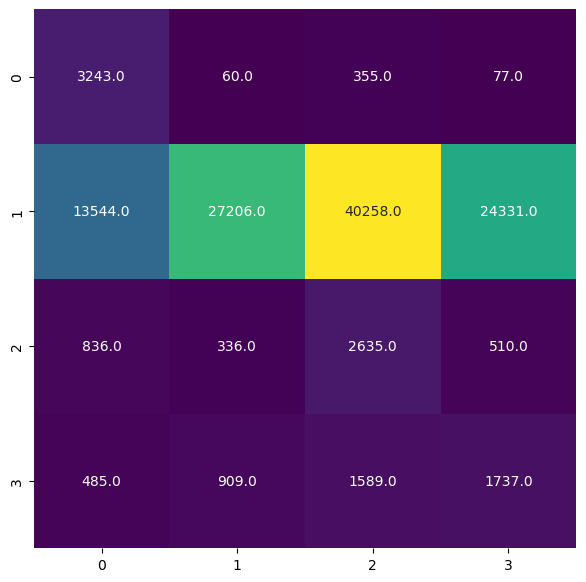

In [24]:
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

MLP with Working_Weekend target

In [4]:
ww_counts = df_MLP_binary.groupBy("Working_Weekend").count()
ww_counts.show()

+---------------+------+
|Working_Weekend| count|
+---------------+------+
|              1| 82649|
|              0|311870|
+---------------+------+



In [4]:
assembler = VectorAssembler(inputCols=num_col_ww, outputCol="features")

output_dataset = assembler.transform(df_MLP_binary)

classificationData = output_dataset.select("features", "Working_Weekend")

classificationData.show(truncate=False)
(trainingData, testData) = classificationData.randomSplit([0.7, 0.3],seed=0)

+-----------------------------------------------------------------------------------------------------------------+---------------+
|features                                                                                                         |Working_Weekend|
+-----------------------------------------------------------------------------------------------------------------+---------------+
|(29,[0,1,2,4,5,6,18,21,22,24],[1.0,33.032551,-81.346909,30.0,93.0,10.0,1.0,3.0,6.0,1.0])                         |0              |
|(29,[0,1,2,3,4,5,6,7,18,21,22,25],[1.0,33.023018,-81.274361,0.129,73.0,47.0,10.0,6.0,1.0,3.0,14.0,1.0])          |0              |
|(29,[0,1,2,3,4,5,6,7,21,22,24],[1.0,33.023848,-81.33301800000002,0.122,82.0,15.0,10.0,7.0,3.0,14.0,1.0])         |0              |
|(29,[0,1,2,4,5,6,21,22,28],[1.0,33.087425,-81.208588,46.0,100.0,0.25,3.0,7.0,1.0])                               |0              |
|(29,[0,1,2,4,5,6,18,21,22,24],[1.0,33.06987,-81.424118,59.0,94.0,10.0,1.0,3

In [6]:
ww_counts_train= trainingData.groupBy("Working_Weekend").count()
ww_counts_train.show()

+---------------+------+
|Working_Weekend| count|
+---------------+------+
|              1| 57897|
|              0|218511|
+---------------+------+



In [7]:
ww_counts_test= testData.groupBy("Working_Weekend").count()
ww_counts_test.show()

+---------------+-----+
|Working_Weekend|count|
+---------------+-----+
|              1|24752|
|              0|93359|
+---------------+-----+



In [5]:
# MLP Layers  -> output layer must have the same number of units of the Working_Weekend classes
layers = [len(num_col_ww),16,8,4,2]

# Create the Multilayer Perceptron Classifier and set its parameters
trainer = MultilayerPerceptronClassifier(
    layers=layers,
    labelCol="Working_Weekend",
    featuresCol="features",
    maxIter=500,  
    tol=1e-6,
    seed=None,
    blockSize=32,
    stepSize=0.03,  
    solver="l-bfgs",
    initialWeights=None,
    probabilityCol="probability",
    rawPredictionCol="rawPrediction"
)

# Train the model
model = trainer.fit(trainingData)

# Make predictions on the test set
predictions= model.transform(testData)

# Compute Test Error = 1-Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(f'Accuracy:{accuracy}\n')
print("Test Error = %g" % (1.0 - accuracy))



#Computing confusion matrix
preds_and_labels = predictions.select(['prediction','Working_Weekend']).withColumn('label', F.col('Working_Weekend').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix())

23/12/13 21:33:19 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=42274Kb max_used=42274Kb free=88797Kb
 bounds [0x000000010a1d8000, 0x000000010cb58000, 0x00000001121d8000]
 total_blobs=15254 nmethods=14085 adapters=1080
 compilation: disabled (not enough contiguous free space left)


Accuracy:0.7913318827204917

Test Error = 0.208668


/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


DenseMatrix([[92302.,   848.],
             [23798.,  1163.]])


Precision for class  0 : 79.50%
Recall for class  0 : 99.09%
avg_F1-Score for class  0 : 88.22%
----------------------------
Precision for class  1 : 57.83%
Recall for class  1 : 4.66%
avg_F1-Score for class  1 : 8.62%
----------------------------
[0.8822174432497013, 0.08623757971229423]
----------------------
avg_F1-Score: 48.42%


<AxesSubplot:>

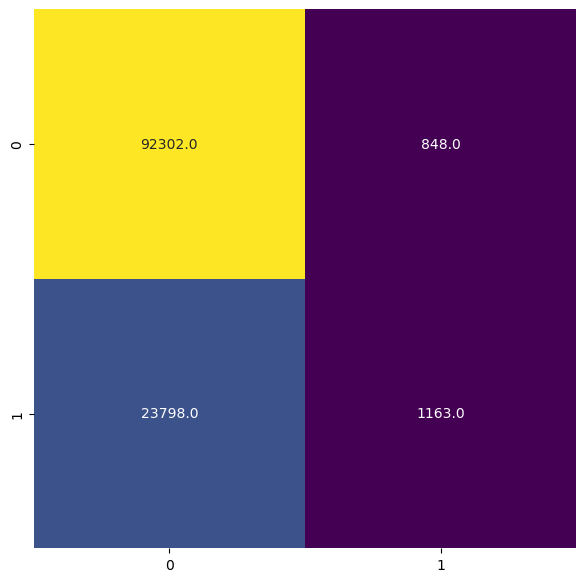

In [8]:
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)